Voynich word and character stats
- quick exploration of tokens, types, bigrams, and Zipf plots
- switch Currier group with `currier='all'|'a'|'b'`, toggle cleaned/raw


In [9]:
import logging
import math
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

from load_voynich_transcription import paragraphs_by_page
from word_stats import (
    word_counter,
    word_length_counts,
    word_bigram_counter,
    char_ngram_counter,
    word_edge_ngram_counter,
    type_token_ratio,
    zipf_series,
)
import reference_languages as ref

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

pbp = paragraphs_by_page  # shorthand
currier = ["a","b"]       # set to "a", "b", or ["a", "b"]
cleaned = True         # toggle cleaning


In [10]:
lang_colors = {"english": "firebrick", "german": "darkorange", "french": "royalblue", "spanish": "goldenrod"}
currier_colors = {"a": "steelblue", "b": "navy", "all": "black"}
comp_langs = [lang for lang in ref.languages if lang in ref.language_stats]
lang_stats = {k: ref.language_stats[k] for k in comp_langs}

def counter_from_json_num(d):
    return Counter({int(k): int(v) for k, v in d.items()}) if d else Counter()

def counter_from_json_str(d):
    return Counter({k: int(v) for k, v in d.items()}) if d else Counter()

lang_counts = {}
for lang, data in lang_stats.items():
    lang_counts[lang] = {
        "wc": counter_from_json_str(data["wc"]),
        "wl_counts": counter_from_json_num(data["wl_counts"]),
        "wb_counts": Counter({tuple(k.split(" ")): int(v) for k, v in data.get("wb_counts", {}).items()}),
        "cb_counts": counter_from_json_str(data["cb_counts"]),
        "ct_counts": counter_from_json_str(data["ct_counts"]),
        "start_bi": counter_from_json_str(data["start_bi"]),
        "end_bi": counter_from_json_str(data["end_bi"]),
        "start_tri": counter_from_json_str(data["start_tri"]),
        "end_tri": counter_from_json_str(data["end_tri"]),
        "tokens": data.get("tokens", 0),
        "types": data.get("types", 0),
    }

log.info({lang: {"tokens": v["tokens"], "types": v["types"]} for lang, v in lang_counts.items()})



INFO:__main__:{'english': {'tokens': 200000, 'types': 9400}, 'german': {'tokens': 200000, 'types': 17567}, 'french': {'tokens': 200000, 'types': 11612}, 'spanish': {'tokens': 200000, 'types': 13349}}


In [11]:
cur_list = currier if isinstance(currier, (list, tuple)) else [currier]
stats_by_cur = {}
for cur in cur_list:
    wc = word_counter(pbp, currier=cur, cleaned=cleaned)
    wl_counts = word_length_counts(pbp, currier=cur, cleaned=cleaned)
    wb_counts = word_bigram_counter(pbp, currier=cur, cleaned=cleaned)
    cb_counts = char_ngram_counter(pbp, n=2, currier=cur, cleaned=cleaned)
    ct_counts = char_ngram_counter(pbp, n=3, currier=cur, cleaned=cleaned)
    start_bi = word_edge_ngram_counter(pbp, n=2, currier=cur, cleaned=cleaned, position="start")
    end_bi = word_edge_ngram_counter(pbp, n=2, currier=cur, cleaned=cleaned, position="end")
    start_tri = word_edge_ngram_counter(pbp, n=3, currier=cur, cleaned=cleaned, position="start")
    end_tri = word_edge_ngram_counter(pbp, n=3, currier=cur, cleaned=cleaned, position="end")
    lengths = list(wl_counts.elements())
    tokens = sum(wc.values())
    types = len(wc)
    hapax = sum(1 for v in wc.values() if v == 1)
    ttr = type_token_ratio(pbp, currier=cur, cleaned=cleaned)
    stats_by_cur[cur] = {
        "wc": wc,
        "wl_counts": wl_counts,
        "wb_counts": wb_counts,
        "cb_counts": cb_counts,
        "ct_counts": ct_counts,
        "start_bi": start_bi,
        "end_bi": end_bi,
        "start_tri": start_tri,
        "end_tri": end_tri,
        "lengths": lengths,
        "tokens": tokens,
        "types": types,
        "ttr": ttr,
        "hapax": hapax,
    }
    log.info({
        "currier": cur,
        "cleaned": cleaned,
        "tokens": tokens,
        "types": types,
        "ttr": round(ttr, 4),
        "hapax": hapax,
        "len_mean": round(float(np.mean(lengths)), 2),
        "len_med": round(float(np.median(lengths)), 2),
        "len_p95": round(float(np.percentile(lengths, 95)), 2),
    })
    log.info(f"top 10 words: {wc.most_common(10)}")
    log.info(f"top 10 word bigrams: {wb_counts.most_common(10)}")
    log.info(f"top 10 char bigrams: {cb_counts.most_common(10)}")
    log.info(f"top 10 char trigrams: {ct_counts.most_common(10)}")
    log.info(f"top start bigrams: {start_bi.most_common(10)}")
    log.info(f"top end bigrams: {end_bi.most_common(10)}")
    log.info(f"top start trigrams: {start_tri.most_common(10)}")
    log.info(f"top end trigrams: {end_tri.most_common(10)}")

wc_all = word_counter(pbp, currier="all", cleaned=cleaned)
stats_all = {
    "wc": wc_all,
    "wb_counts": word_bigram_counter(pbp, currier="all", cleaned=cleaned),
    "cb_counts": char_ngram_counter(pbp, n=2, currier="all", cleaned=cleaned),
    "ct_counts": char_ngram_counter(pbp, n=3, currier="all", cleaned=cleaned),
    "start_bi": word_edge_ngram_counter(pbp, n=2, currier="all", cleaned=cleaned, position="start"),
    "end_bi": word_edge_ngram_counter(pbp, n=2, currier="all", cleaned=cleaned, position="end"),
    "start_tri": word_edge_ngram_counter(pbp, n=3, currier="all", cleaned=cleaned, position="start"),
    "end_tri": word_edge_ngram_counter(pbp, n=3, currier="all", cleaned=cleaned, position="end"),
}
log.info({"currier": "all", "tokens": sum(wc_all.values()), "types": len(wc_all)})


INFO:__main__:{'currier': 'a', 'cleaned': True, 'tokens': 17324, 'types': 4760, 'ttr': 0.2748, 'hapax': 3308, 'len_mean': 5.15, 'len_med': 5.0, 'len_p95': 8.0}
INFO:__main__:top 10 words: [('daiin', 434), ('aiin', 247), ('chol', 215), ('chedy', 203), ('qokeey', 184), ('ol', 178), ('ar', 169), ('chey', 164), ('al', 150), ('qokeedy', 138)]
INFO:__main__:top 10 word bigrams: [(('or', 'aiin'), 22), (('chol', 'daiin'), 18), (('ar', 'al'), 18), (('s', 'aiin'), 17), (('chedy', 'qokeey'), 15), (('daiin', 'daiin'), 13), (('ar', 'aiin'), 11), (('qokeedy', 'qokeedy'), 11), (('shey', 'qokain'), 10), (('qokeey', 'qokeey'), 10)]
INFO:__main__:top 10 char bigrams: [('ch', 5501), ('he', 3778), ('ai', 3571), ('in', 3166), ('ok', 2772), ('ee', 2743), ('dy', 2727), ('qo', 2459), ('ii', 2451), ('ol', 2304)]
INFO:__main__:top 10 char trigrams: [('che', 2540), ('iin', 2217), ('aii', 2196), ('edy', 1674), ('qok', 1393), ('cho', 1359), ('oke', 1207), ('kee', 1194), ('dai', 1160), ('hed', 1054)]
INFO:__main__:

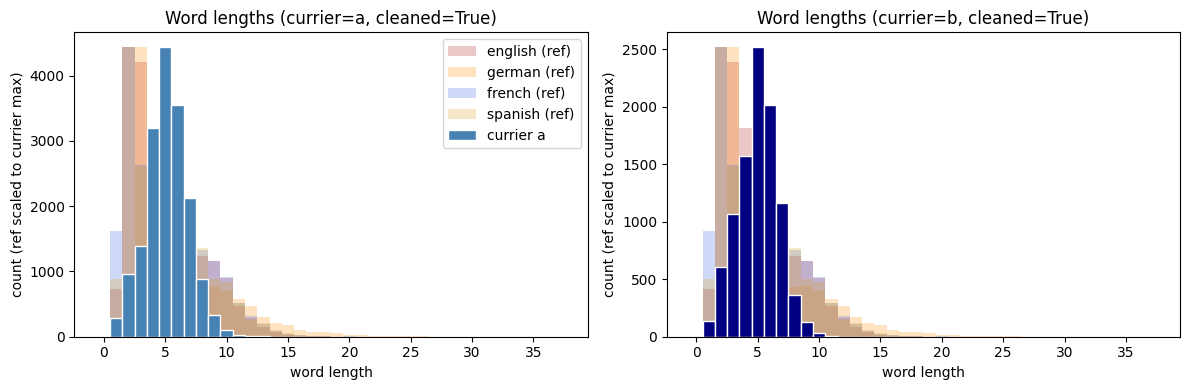

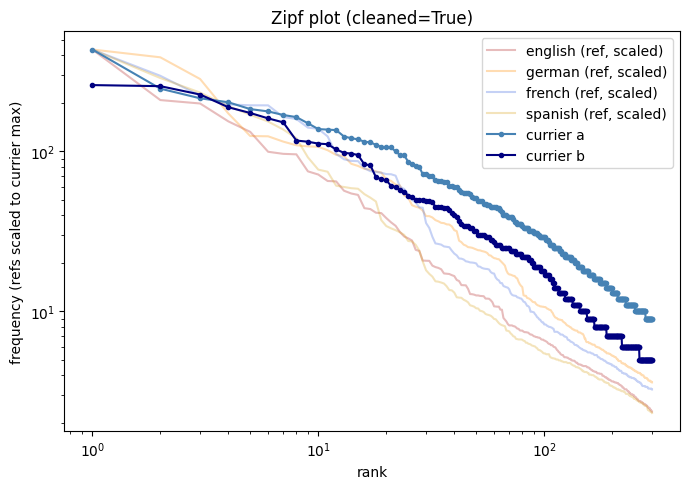

In [12]:
fig, axes = plt.subplots(1, len(cur_list), figsize=(6 * len(cur_list), 4))
axes = np.atleast_1d(axes)
for ax, cur in zip(axes, cur_list):
    wl_counts_cur = stats_by_cur[cur]["wl_counts"]
    max_len_candidates = [max(wl_counts_cur) if wl_counts_cur else 0]
    max_len_candidates += [max(data["wl_counts"]) if data["wl_counts"] else 0 for data in lang_counts.values()]
    bins = range(0, max(max_len_candidates) + 2)
    counts_cur, _ = np.histogram(list(wl_counts_cur.elements()), bins=bins)
    cur_max = counts_cur.max() if len(counts_cur) else 1
    for lang, data in lang_counts.items():
        arr = list(data["wl_counts"].elements())
        if not arr:
            continue
        counts_ref, _ = np.histogram(arr, bins=bins)
        ref_max = counts_ref.max() or 1
        scale = cur_max / ref_max if ref_max else 1
        ax.bar(np.array(bins[:-1]), counts_ref * scale, width=1.0, color=lang_colors.get(lang, "gray"), alpha=0.25, edgecolor="none", label=f"{lang} (ref)" if ax == axes[0] else None)
    ax.bar(np.array(bins[:-1]), counts_cur, width=1.0, color=currier_colors.get(cur, "black"), edgecolor="white", label=f"currier {cur}")
    ax.set_xlabel("word length")
    ax.set_ylabel("count (ref scaled to currier max)")
    ax.set_title(f"Word lengths (currier={cur}, cleaned={cleaned})")
    if ax == axes[0]:
        ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
cur_max_freq = 0
cur_zipf = {}
for cur in cur_list:
    ranks, freqs = zipf_series(stats_by_cur[cur]["wc"], top_n=300)
    cur_zipf[cur] = (ranks, freqs)
    if freqs:
        cur_max_freq = max(cur_max_freq, max(freqs))
for lang, data in lang_counts.items():
    ranks, freqs = zipf_series(data["wc"], top_n=300)
    ref_max = max(freqs) if freqs else 0
    scale = cur_max_freq / ref_max if ref_max else 1
    freqs_scaled = [f * scale for f in freqs]
    ax.loglog(ranks, freqs_scaled, color=lang_colors.get(lang, "gray"), alpha=0.3, label=f"{lang} (ref, scaled)")
for cur, (ranks, freqs) in cur_zipf.items():
    ax.loglog(ranks, freqs, marker=".", color=currier_colors.get(cur, "black"), label=f"currier {cur}")
ax.set_xlabel("rank")
ax.set_ylabel("frequency (refs scaled to currier max)")
ax.set_title(f"Zipf plot (cleaned={cleaned})")
ax.legend()
plt.tight_layout()
plt.show()


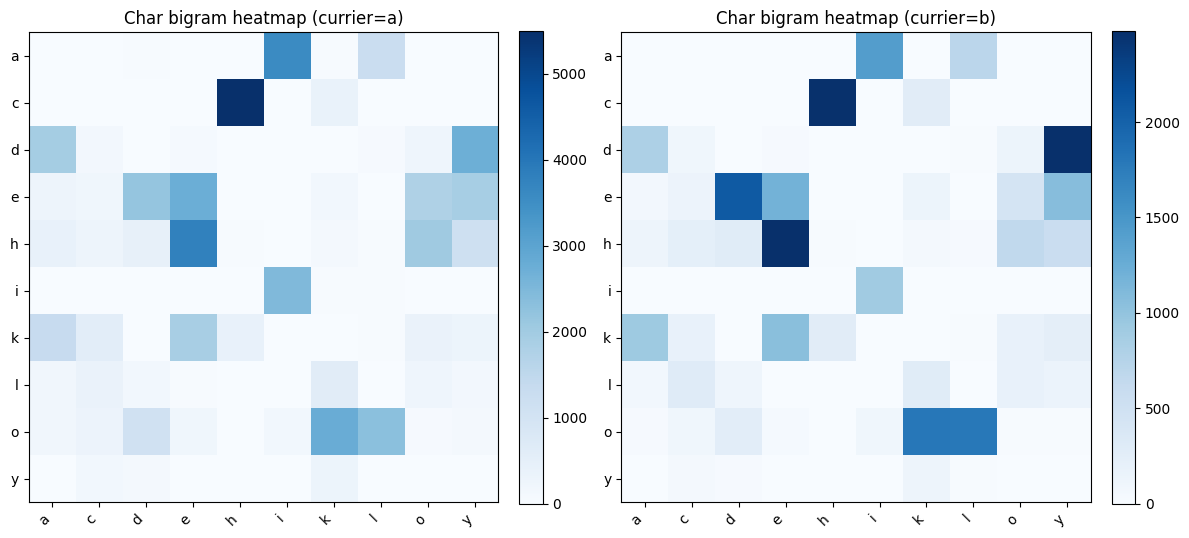

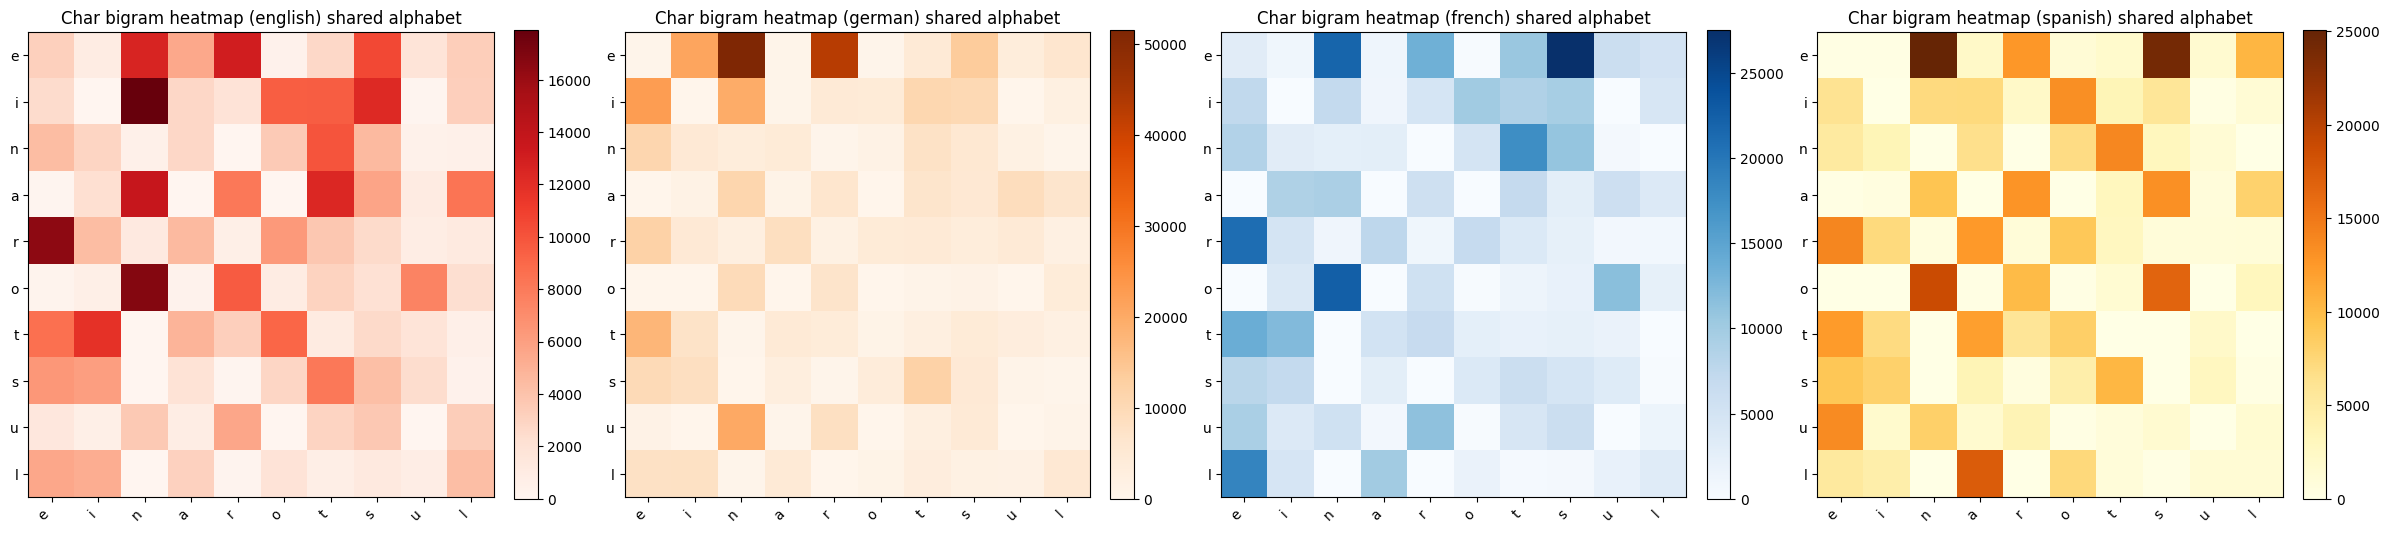

In [19]:
top_chars = 10
combined_char_freq = Counter()
for cur in cur_list:
    for (c1, c2), cnt in stats_by_cur[cur]["cb_counts"].items():
        combined_char_freq[c1] += cnt
        combined_char_freq[c2] += cnt
alphabet = [c for c, _ in combined_char_freq.most_common(top_chars)] if combined_char_freq else []
alphabet = sorted(alphabet)
idx = {c: i for i, c in enumerate(alphabet)}

lang_cmaps = {"english": "Reds", "german": "Oranges", "french": "Blues", "spanish": "YlOrBr"}

if alphabet:
    fig, axes = plt.subplots(1, len(cur_list), figsize=(6 * len(cur_list), 6))
    axes = np.atleast_1d(axes)
    for ax, cur in zip(axes, cur_list):
        cb_counts = stats_by_cur[cur]["cb_counts"]
        mat = np.zeros((len(alphabet), len(alphabet)), dtype=int)
        for (c1, c2), cnt in cb_counts.items():
            if c1 in idx and c2 in idx:
                mat[idx[c1], idx[c2]] = cnt
        im = ax.imshow(mat, cmap="Blues")
        ax.set_xticks(range(len(alphabet)))
        ax.set_yticks(range(len(alphabet)))
        ax.set_xticklabels(alphabet, rotation=45, ha="right")
        ax.set_yticklabels(alphabet)
        ax.set_title(f"Char bigram heatmap (currier={cur})")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
    if lang_counts:
        if False:
            fig, axes = plt.subplots(1, len(lang_counts), figsize=(6 * len(lang_counts), 6))
            axes = np.atleast_1d(axes)
            for ax, (lang, data) in zip(axes, lang_counts.items()):
                cb_counts = data["cb_counts"]
                if not cb_counts:
                    ax.set_title(f"Char bigram heatmap ({lang}) - no data")
                    continue
                char_freq = Counter()
                for bg, cnt in cb_counts.items():
                    if len(bg) >= 2:
                        char_freq[bg[0]] += cnt
                        char_freq[bg[1]] += cnt
                alphabet_lang = [c for c, _ in char_freq.most_common(top_chars)]
                alphabet_lang = sorted(alphabet_lang)
                if not alphabet_lang:
                    ax.set_title(f"Char bigram heatmap ({lang}) - empty alphabet")
                    continue
                idx_lang = {c: i for i, c in enumerate(alphabet_lang)}
                mat = np.zeros((len(alphabet_lang), len(alphabet_lang)), dtype=int)
                for bg, cnt in cb_counts.items():
                    if len(bg) >= 2:
                        c1, c2 = bg[0], bg[1]
                        if c1 in idx_lang and c2 in idx_lang:
                            mat[idx_lang[c1], idx_lang[c2]] += cnt
                vmax = mat.max()
                cmap_lang = lang_cmaps.get(lang, "Blues")
                im = ax.imshow(mat, cmap=cmap_lang, vmin=0, vmax=max(1, vmax))
                ax.set_xticks(range(len(alphabet_lang)))
                ax.set_yticks(range(len(alphabet_lang)))
                ax.set_xticklabels(alphabet_lang, rotation=45, ha="right")
                ax.set_yticklabels(alphabet_lang)
                ax.set_title(f"Char bigram heatmap ({lang})")
                fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            plt.tight_layout()
            plt.show()
        # Combined-top-letter reference heatmaps (shared alphabet across refs)
        if True:
            combined_chars = Counter()
            for data in lang_counts.values():
                for bg, cnt in data["cb_counts"].items():
                    if len(bg) >= 2:
                        combined_chars[bg[0]] += cnt
                        combined_chars[bg[1]] += cnt
            combined_letters = [c for c, _ in combined_chars.most_common(top_chars)]
            if combined_letters:
                idx_comb = {c: i for i, c in enumerate(combined_letters)}
                fig, axes = plt.subplots(1, len(lang_counts), figsize=(6 * len(lang_counts), 6))
                axes = np.atleast_1d(axes)
                for ax, (lang, data) in zip(axes, lang_counts.items()):
                    mat = np.zeros((len(combined_letters), len(combined_letters)), dtype=int)
                    for bg, cnt in data["cb_counts"].items():
                        if len(bg) >= 2:
                            c1, c2 = bg[0], bg[1]
                            if c1 in idx_comb and c2 in idx_comb:
                                mat[idx_comb[c1], idx_comb[c2]] += cnt
                    vmax = mat.max()
                    cmap_lang = lang_cmaps.get(lang, "Blues")
                    im = ax.imshow(mat, cmap=cmap_lang, vmin=0, vmax=max(1, vmax))
                    ax.set_xticks(range(len(combined_letters)))
                    ax.set_yticks(range(len(combined_letters)))
                    ax.set_xticklabels(combined_letters, rotation=45, ha="right")
                    ax.set_yticklabels(combined_letters)
                    ax.set_title(f"Char bigram heatmap ({lang}) shared alphabet")
                    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                plt.tight_layout()
                plt.show()
else:
    print("No bigram characters available for heatmap")



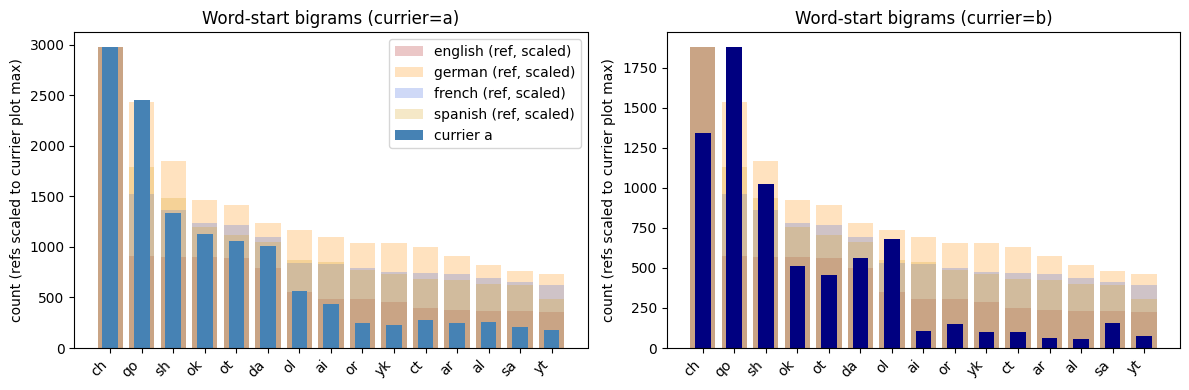

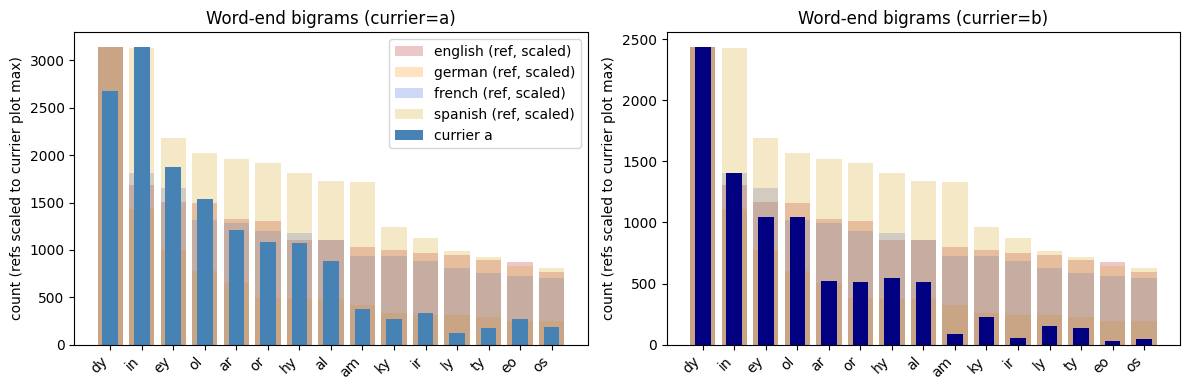

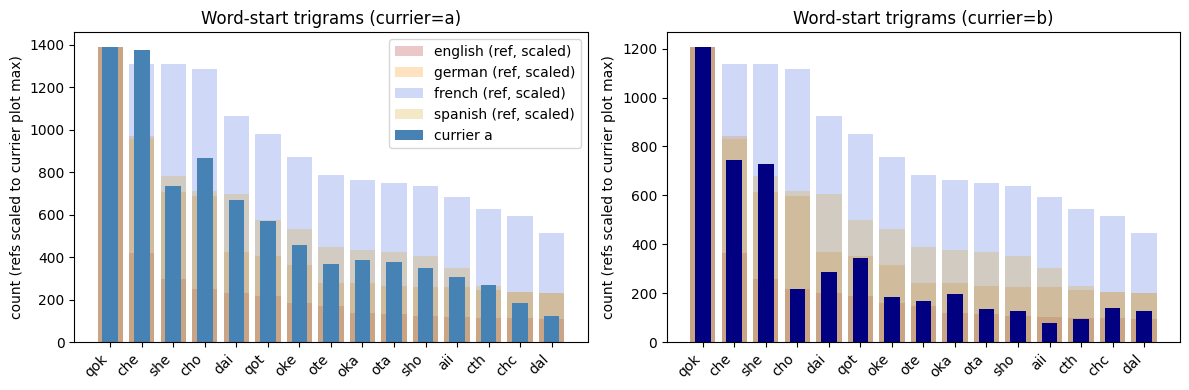

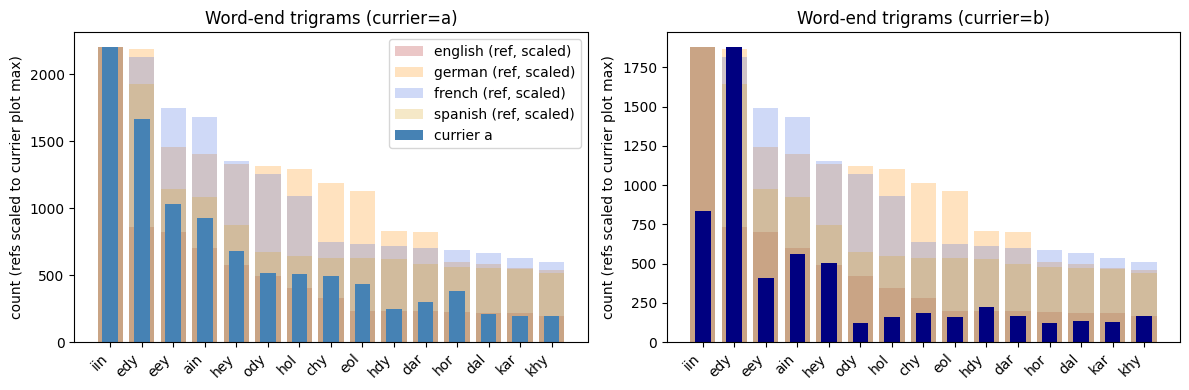

In [14]:
top_edge = 15

def plot_edges(key, title):
    base_labels = [l for l, _ in stats_all[key].most_common(top_edge)]
    if not base_labels:
        print(f"No data for {title}")
        return
    base_x = np.arange(len(base_labels))
    fig, axes = plt.subplots(1, len(cur_list), figsize=(6 * len(cur_list), 4))
    axes = np.atleast_1d(axes)
    for ax, cur in zip(axes, cur_list):
        cnt = stats_by_cur[cur][key]
        vals_cur = [cnt.get(l, 0) for l in base_labels]
        base_max = max(vals_cur) if any(vals_cur) else 1
        for lang, data in lang_counts.items():
            ref_items = data[key].most_common(top_edge)
            ref_labels = [l for l, _ in ref_items]
            ref_vals = [v for _, v in ref_items]
            ref_max = max(ref_vals) if ref_vals else 1
            scale = base_max / ref_max if ref_max else 1
            x_ref = np.arange(len(ref_labels))
            vals_ref = [v * scale for v in ref_vals]
            ax.bar(x_ref, vals_ref, color=lang_colors.get(lang, "gray"), alpha=0.25, width=0.8, label=f"{lang} (ref, scaled)" if ax == axes[0] else None)
        ax.bar(base_x, vals_cur, color=currier_colors.get(cur, "black"), width=0.5, label=f"currier {cur}")
        ax.set_xticks(base_x)
        ax.set_xticklabels(base_labels, rotation=45, ha="right")
        ax.set_ylabel("count (refs scaled to currier plot max)")
        ax.set_title(f"{title} (currier={cur})")
        if ax == axes[0]:
            ax.legend()
    plt.tight_layout()
    plt.show()

plot_edges("start_bi", "Word-start bigrams")
plot_edges("end_bi", "Word-end bigrams")
plot_edges("start_tri", "Word-start trigrams")
plot_edges("end_tri", "Word-end trigrams")



In [15]:
summary = {}
for cur, vals in stats_by_cur.items():
    summary[cur] = {
        "tokens": vals["tokens"],
        "types": vals["types"],
        "ttr": vals["ttr"],
        "hapax": vals["hapax"],
        "top_words": vals["wc"].most_common(10),
        "top_word_bigrams": vals["wb_counts"].most_common(10),
        "top_char_bigrams": vals["cb_counts"].most_common(10),
        "top_start_bigrams": vals["start_bi"].most_common(10),
        "top_end_bigrams": vals["end_bi"].most_common(10),
        "top_start_trigrams": vals["start_tri"].most_common(10),
        "top_end_trigrams": vals["end_tri"].most_common(10),
    }
summary


{'a': {'tokens': 17324,
  'types': 4760,
  'ttr': 0.27476333410297854,
  'hapax': 3308,
  'top_words': [('daiin', 434),
   ('aiin', 247),
   ('chol', 215),
   ('chedy', 203),
   ('qokeey', 184),
   ('ol', 178),
   ('ar', 169),
   ('chey', 164),
   ('al', 150),
   ('qokeedy', 138)],
  'top_word_bigrams': [(('or', 'aiin'), 22),
   (('chol', 'daiin'), 18),
   (('ar', 'al'), 18),
   (('s', 'aiin'), 17),
   (('chedy', 'qokeey'), 15),
   (('daiin', 'daiin'), 13),
   (('ar', 'aiin'), 11),
   (('qokeedy', 'qokeedy'), 11),
   (('shey', 'qokain'), 10),
   (('qokeey', 'qokeey'), 10)],
  'top_char_bigrams': [('ch', 5501),
   ('he', 3778),
   ('ai', 3571),
   ('in', 3166),
   ('ok', 2772),
   ('ee', 2743),
   ('dy', 2727),
   ('qo', 2459),
   ('ii', 2451),
   ('ol', 2304)],
  'top_start_bigrams': [('ch', 2973),
   ('qo', 2450),
   ('sh', 1336),
   ('ok', 1131),
   ('ot', 1063),
   ('da', 1009),
   ('ol', 560),
   ('ai', 432),
   ('lk', 362),
   ('ct', 278)],
  'top_end_bigrams': [('in', 3139),
   (